In [1]:
import sys
print("Python executable path used by Jupyter:", sys.executable)
print("Python environment prefix used by Jupyter:", sys.prefix)

Python executable path used by Jupyter: /home/daniel/miniconda3/envs/md_env/bin/python
Python environment prefix used by Jupyter: /home/daniel/miniconda3/envs/md_env


RDKit imported successfully!
OpenFF Molecule imported successfully!
OpenFF ForceField imported successfully!


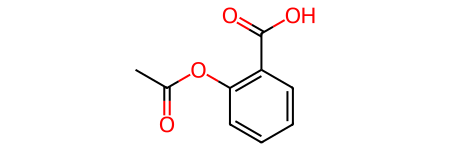


OpenFF Molecule created:
Molecule with name '2244' and SMILES '[H][O][C](=[O])[c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[O][C](=[O])[C]([H])([H])[H]'

ForceField loaded:


In [2]:
from rdkit import Chem
from openff.toolkit.topology import Molecule
from openff.toolkit.typing.engines.smirnoff.forcefield import ForceField

print("RDKit imported successfully!")
print("OpenFF Molecule imported successfully!")
print("OpenFF ForceField imported successfully!")

# Example: Aspirin from PubChem (as we did before)
import requests
aspirin_cid = 2244
pubchem_url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{aspirin_cid}/SDF?record_type=2d'
response = requests.get(pubchem_url)
response.raise_for_status()
aspirin_content = response.text

rdmol = Chem.MolFromMolBlock(aspirin_content)
offmol = Molecule.from_rdkit(rdmol)
forcefield = ForceField("openff-2.2.0.offxml") # Or "amber/ff14SB_off_impro_smirnoff_0.0.2.offxml" etc.
interchange = forcefield.create_interchange(offmol.to_topology())

display(rdmol) # If you imported display from IPython.display
print("\nOpenFF Molecule created:")
print(offmol)
print("\nForceField loaded:")
print(forcefield)

In [4]:
import openmm.app as app
import openmm as om
import openmm.unit as unit
import mdtraj as md
import nglview as ngl
from openmm.app import StateDataReporter, DCDReporter

def simulate_and_visualize(interchange):
    # OpenMM setup
    integrator = om.LangevinMiddleIntegrator(
        300 * unit.kelvin,
        1 / unit.picosecond,
        0.002 * unit.picoseconds)
    simulation = interchange.to_openmm_simulation(integrator)
    simulation.minimizeEnergy(tolerance=100)
    dcd_reporter = om.app.DCDReporter(file="trajectory.dcd", reportInterval=10)

    simulation.reporters.append(dcd_reporter)
    simulation.step(1000)
    # trajectory visualization
    trajectory: md.Trajectory = md.load(
        "trajectory.dcd", top=md.Topology.from_openmm(interchange.to_openmm_topology()))
    view = ngl.show_mdtraj(trajectory)
    view.add_representation("line", selection="protein")
    view.add_line(selection="water")
    return view

simulate_and_visualize(interchange)

NGLWidget(max_frame=99)

# OpenFF Objects, protein-ligand simulation

In [9]:
from openff.toolkit import ForceField, Molecule, Topology

top = Topology.from_pdb(
    "complex_topology.pdb",
    unique_molecules = [Molecule.from_smiles("c12c(Cl)cccc1sc(C(=O)[O-])c(Cl)2")])
protein = top.molecule(0)
ligand = top.molecule(1)
top.visualize()

NGLWidget()

In [13]:
from pdbfixer import PDBFixer
# solvating the topology
top.to_file('temp.pdb')
fixer = PDBFixer('temp.pdb')
fixer.addSolvent(padding = 0.5*unit.nanometer, ionicStrength = 0.15 * unit.molar)

with open("receptor_solvated.pdb", "w") as f:
    app.PDBFile.writeFile(fixer.topology, fixer.positions, f)
top = Topology.from_pdb("receptor_solvated.pdb",
                        unique_molecules = [top.molecule(1)])
top.visualize()

NGLWidget()

In [17]:
ff = ForceField("openff-2.2.0.offxml", "ff14sb_off_impropers_0.0.4.offxml") # small molecules from openff, proteins from amber
interchange = ff.create_interchange(top)
integrator = om.LangevinMiddleIntegrator(
        300 * unit.kelvin,
        1 / unit.picosecond,
        0.002 * unit.picoseconds)
simulation = interchange.to_openmm_simulation(integrator)
simulation.minimizeEnergy(tolerance=100)
dcd_reporter = om.app.DCDReporter(file="trajectory.dcd", reportInterval=10)

simulation.reporters.append(dcd_reporter)
simulation.step(1000)

trajectory: md.Trajectory = md.load(
"trajectory.dcd", top=md.Topology.from_openmm(interchange.to_openmm_topology()))
view = ngl.show_mdtraj(trajectory)
view.add_representation("line", selection="protein")
view.add_line(selection="water")
view

NGLWidget(max_frame=99)